# Stylometry - model training

### Used classifiers
 - Decision Tree
 - kNN (NYI)
 - SVM (NYI)
 
 
 - ? Logistic Regression (NYI)

## Imports

In [16]:
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn import preprocessing
from dateutil import parser
import statistics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.impute import KNNImputer
from sklearn import tree, svm
from skmultilearn.model_selection import IterativeStratification
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def evaluate(real, predicted):
    print("Evaluation: ")
    countGood = 0
    total = len(real)
    falsePos = 0
    falseNeg = 0
    truePos = 0
    trueNeg = 0
    if total != len(predicted):
        print("Non-matching sample lengths")
        return None
    for i in range(0, total):
        countGood += 1 if real[i] == predicted[i] else 0

    # accuracy = str(countGood / total)
    # precision = str(truePos / (truePos + falsePos))
    # recall = str(truePos / (truePos + falseNeg))
    
    print("accuracy " + str(countGood / total))

## Data import
\+calculate positional error occurence per token

In [38]:

df_all = pd.read_csv('dataParsedDirectionsFromAll.csv', sep=',')
df_all['Toperror_pertokens'] = df_all['Toperror'] / df_all['Tokens']
df_all['Lefterror_pertokens'] = df_all['Lefterror'] / df_all['Tokens']
df_all['Righterror_pertokens'] = df_all['Righterror'] / df_all['Tokens']
df_all['Downerror_pertokens'] = df_all['Downerror'] / df_all['Tokens']
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20376 entries, 0 to 20375
Data columns (total 71 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Author                             20376 non-null  int64  
 1   UppercaseLetter                    20376 non-null  int64  
 2   UppercaseLetter_pertokens          20363 non-null  float64
 3   LowercaseLetter                    20376 non-null  int64  
 4   LowercaseLetter_pertokens          20363 non-null  float64
 5   TitlecaseLetter                    20376 non-null  int64  
 6   TitlecaseLetter_pertokens          20363 non-null  float64
 7   ModifierLetter                     20376 non-null  int64  
 8   ModifierLetter_pertokens           20363 non-null  float64
 9   OtherLetter                        20376 non-null  int64  
 10  OtherLetter_pertokens              20363 non-null  float64
 11  NonSpacingMark                     20376 non-null  int

## Dataframes
df_all - contains all feature columns and author id

df_positional - contains positional errors, token count, misspell ratio and author id

In [44]:
selected_cols = ['UppercaseLetter_pertokens',
                 'LowercaseLetter_pertokens',
                 'MathSymbol_pertokens',
                 'Author',
                 'OtherLetter_pertokens',
                 'Toperror_pertokens',
                 'Lefterror_pertokens',
                 'Righterror_pertokens',
                 'CurrencySymbol_pertokens',
                 'OtherNotAssigned_pertokens',
                 'Downerror_pertokens',
                 'Misspellratio',
                 'ConnectorPunctuation_pertokens']

df_positional = df_all[selected_cols]
df_positional

,UppercaseLetter_pertokens,LowercaseLetter_pertokens,MathSymbol_pertokens,Author,OtherLetter_pertokens,Toperror_pertokens,Lefterror_pertokens,Righterror_pertokens,CurrencySymbol_pertokens,OtherNotAssigned_pertokens,Downerror_pertokens,Misspellratio,ConnectorPunctuation_pertokens
0,1.226,1.935,0.0,13,0.0,0.000000,0.064516,0.000000,0.000,0.0,0.000000,0.105,0.0
1,0.286,2.976,0.0,13,0.0,0.000000,0.023810,0.000000,0.000,0.0,0.000000,0.033,0.0
2,0.150,3.485,0.0,13,0.0,0.000000,0.023952,0.035928,0.000,0.0,0.000000,0.133,0.0
3,0.174,3.228,0.0,13,0.0,0.000000,0.000000,0.000000,0.011,0.0,0.000000,0.004,0.0
4,0.099,3.665,0.0,13,0.0,0.006211,0.031056,0.024845,0.000,0.0,0.000000,0.118,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20371,0.159,3.651,0.0,19,0.0,0.000000,0.000000,0.015873,0.000,0.0,0.000000,0.021,0.0
20372,0.130,3.558,0.0,19,0.0,0.000000,0.025974,0.064935,0.000,0.0,0.000000,0.118,0.0
20373,1.143,2.143,0.0,19,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000,0.0
20374,0.012,4.000,0.0,19,0.0,0.000000,0.035294,0.035294,0.000,0.0,0.011765,0.044,0.0


### Filtering
removing NaN and inf values

In [45]:
df_positional.dropna()
indices_to_keep = ~df_positional.isin([np.nan, np.inf, -np.inf]).any(1)
df_positional = df_positional[indices_to_keep].astype(np.float64)
df_positional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20357 entries, 0 to 20375
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   UppercaseLetter_pertokens       20357 non-null  float64
 1   LowercaseLetter_pertokens       20357 non-null  float64
 2   MathSymbol_pertokens            20357 non-null  float64
 3   Author                          20357 non-null  float64
 4   OtherLetter_pertokens           20357 non-null  float64
 5   Toperror_pertokens              20357 non-null  float64
 6   Lefterror_pertokens             20357 non-null  float64
 7   Righterror_pertokens            20357 non-null  float64
 8   CurrencySymbol_pertokens        20357 non-null  float64
 9   OtherNotAssigned_pertokens      20357 non-null  float64
 10  Downerror_pertokens             20357 non-null  float64
 11  Misspellratio                   20357 non-null  float64
 12  ConnectorPunctuation_pertokens  

## OPTIONAL 
+ for binary classification testing, pick only authors with 2 distinct IDs

+ One vs. all

In [259]:
# df_positional = df_positional[(df_positional["Author"] == 13.0) | (df_positional["Author"] == 16.0)]

# df_positional['Author'] = df_positional['Author'].apply(lambda x: 1 if x == 13 else 0)

# Split to train/test
!TODO, only taking a random sample and testing it on itself

In [47]:
data_count = len(df_positional)
percentage_to_train = 0.60
df_train = df_positional.sample(int(data_count*(percentage_to_train)))
df_test = pd.concat([df_train, df_positional]).drop_duplicates(keep=False)
# df_test = df_positional[int(data_count*2/3):]
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12214 entries, 4374 to 8913
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   UppercaseLetter_pertokens       12214 non-null  float64
 1   LowercaseLetter_pertokens       12214 non-null  float64
 2   MathSymbol_pertokens            12214 non-null  float64
 3   Author                          12214 non-null  float64
 4   OtherLetter_pertokens           12214 non-null  float64
 5   Toperror_pertokens              12214 non-null  float64
 6   Lefterror_pertokens             12214 non-null  float64
 7   Righterror_pertokens            12214 non-null  float64
 8   CurrencySymbol_pertokens        12214 non-null  float64
 9   OtherNotAssigned_pertokens      12214 non-null  float64
 10  Downerror_pertokens             12214 non-null  float64
 11  Misspellratio                   12214 non-null  float64
 12  ConnectorPunctuation_pertokens

### Split training into features and labels

In [48]:
X = df_train.drop('Author', axis=1)
y = df_train["Author"]

# Model fitting
### Decision Tree Classifier
Create a decision tree classifier and get predictions on the same dataset

In [49]:
dt = tree.DecisionTreeClassifier(random_state=2)
dt = dt.fit(X, y)
predictions = dt.predict(X)
predictions

array([40., 99., 18., ..., 80., 10., 84.])

In [50]:
real_authors = df_train["Author"].to_numpy()
real_authors

array([40., 99., 18., ..., 80., 10., 84.])

### SVM

In [61]:
rbf = svm.SVC(kernel='rbf', gamma=0.3, C=0.2).fit(X, y)

In [ ]:
poly = svm.SVC(kernel='poly', degree=2, C=2).fit(X, y)

### Logistic Regression

In [51]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X, y)

LogisticRegression(random_state=0, solver='liblinear')

## Evaluation
Create features and labels from testing dataset

In [53]:
X_test = df_test.drop('Author', axis=1)
Y_test = df_test['Author'].to_numpy()

## DT

In [54]:
# Decision Tree
predictions = dt.predict(X_test)
evaluate(Y_test, predictions)

Evaluation: 
accuracy 0.037064584108094704


## SVM

In [ ]:
predictions_rbf = rbf.predict(X_test)
evaluate(Y_test, predictions_rbf)

In [ ]:
predictions_poly = poly.predict(X_test)
evaluate(Y_test, predictions_poly)

### LogReg

In [55]:
predictions_logreg = model.predict(X)
evaluate(real_authors, predictions_logreg)

Evaluation: 
accuracy 0.06451612903225806


In [269]:
for i in range(0, np.minimum(len(Y_test), 10)):
    print(str(Y_test[i]) + "=" + str(predictions[i]))

13.0=16.0
13.0=16.0
13.0=16.0
13.0=16.0
13.0=16.0
13.0=13.0
13.0=16.0
13.0=13.0
16.0=16.0
16.0=16.0


# Other -------- UNRELATED -------
under construction

## Automatic feature selection

In [42]:
def select_features(df, k=5):
    df_normal = minMax_scaling(df)
    df_normal = df_normal.drop(["Author"], axis=1)
    indicators_indexed = []
    for x in df['Author']:
        indicators_indexed.append(x)
#     print(len(indicators_indexed))
    # print(df_normal)
    np.random.seed(1)
    k_best_features = SelectKBest(mutual_info_regression, k=k).fit_transform(df_normal.values, indicators_indexed)
    return k_best_features

<AxesSubplot:>

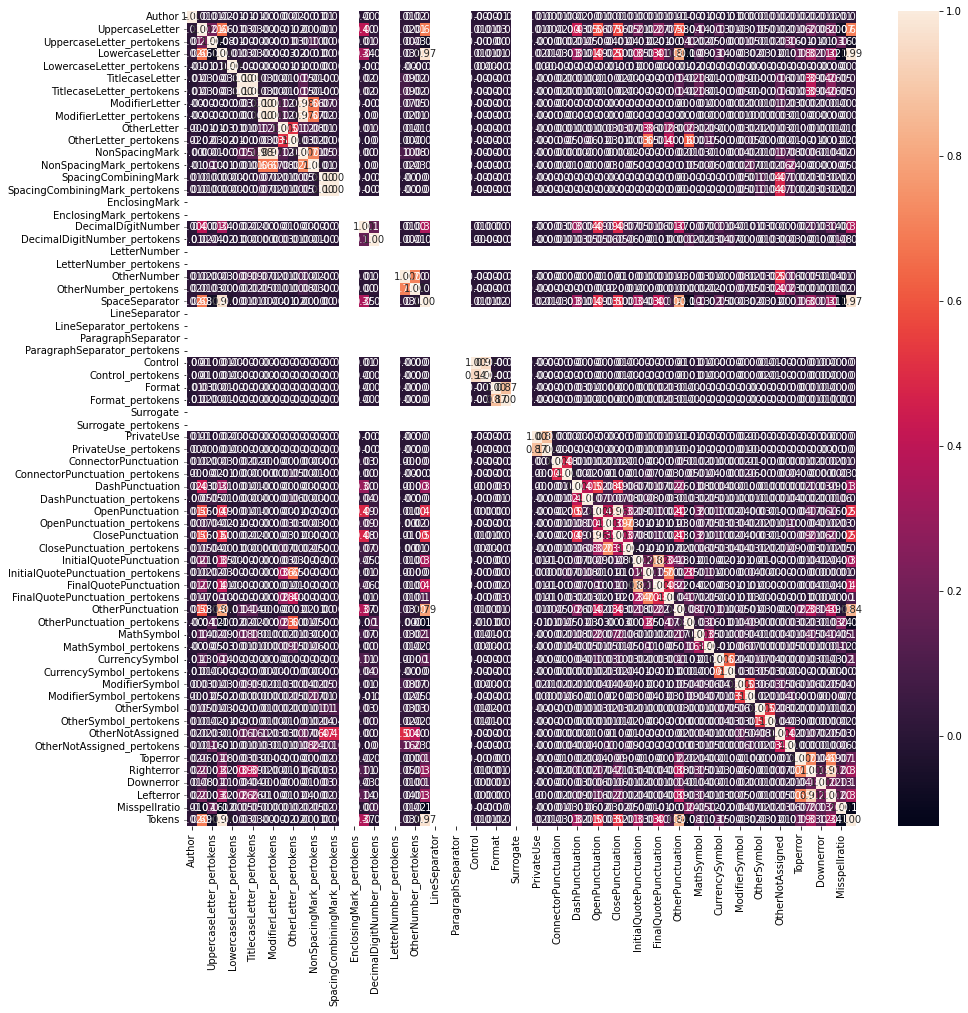

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_all.corr() , ax=ax, annot=True, fmt=".2f")